Showing the DDSP models we have trained


## Install Dependencies

In [1]:
# %tensorflow_version 2.x
# !pip install -qU ddsp[data_preparation]==1.0.1

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import os
import ddsp
import ddsp.training
import gin

import matplotlib
import IPython.display as ipd
import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt
import scipy as sp
import librosa
import librosa.display
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds  

import utils

sample_rate = 16000

## Reading audios and computing (f0,loudness,z)

### Using the given [python file](https://github.com/magenta/ddsp/blob/master/ddsp/spectral_ops.py) in ddsp library to compute $f0$ and loudness.
* *ddsp.spectral_ops.compute_f0*

* *ddsp.spectral_ops.compute_loudness*

shape of original signal: (4525632,) 
 original sample rate: 22050
audio shape: (160000,)


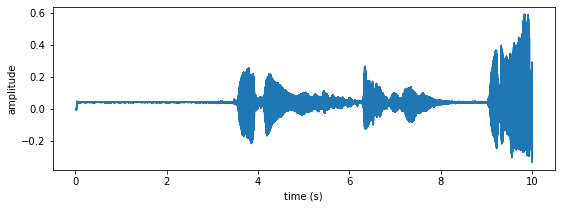

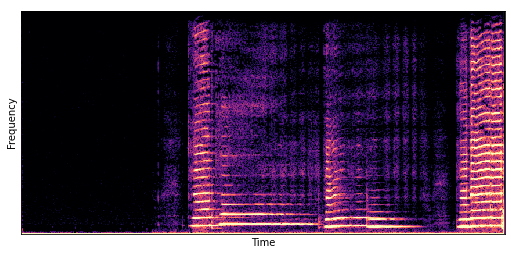

In [3]:
sig, sr = librosa.load('./Pretraine_ models_for_T2/DDSP_saxophone_without_z/SAX.wav') #data,samplerate
print('shape of original signal:',np.shape(sig),'\n','original sample rate:',sr)

# resample (down sampling to 16kHz) and take the first 10 seconds
sig_re = librosa.resample(sig,sr,sample_rate)
# print(sig_re)
audio = sig_re[:10*sample_rate]
#print(audio[:16000])
#audio = audio[np.newaxis,:]

T_all = audio.shape[0]
time = np.arange(T_all)/sample_rate

plt.figure(figsize=(9,3))
plt.plot(time, audio)
plt.xlabel('time (s)')
plt.ylabel('amplitude')
    
ipd.Audio(audio, rate = sample_rate) 
print('audio shape:',np.shape(audio))

# Calculating Spectrogram
utils.specplot(audio)

Text(0, 0.5, 'Loudness')

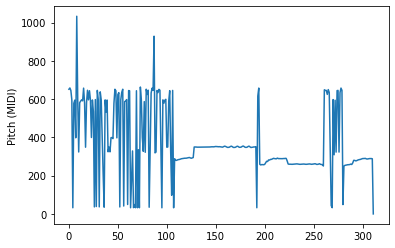

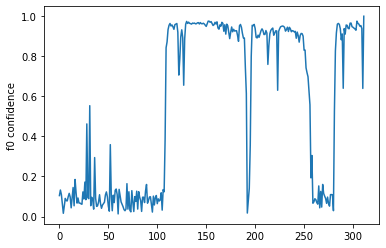

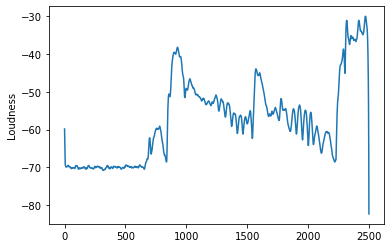

In [4]:
#extracting f0 with CREPE
ddsp.spectral_ops.reset_crepe()
f0_crepe, f0_confidence = ddsp.spectral_ops.compute_f0(audio, 
                                                       sample_rate= sample_rate,
                                                       frame_rate=31.25,
                                                       viterbi=False)
#extracting loudness 
loudness =ddsp.spectral_ops.compute_loudness(audio,
                     sample_rate= sample_rate,
                     frame_rate=250,
                     n_fft=2048,
                     ref_db=20.7,
                     use_tf=False)

audio_features_key = ['audio','f0_hz','f0_confidence','loundness_db']
audio_features = dict([(k,[]) for k in audio_features_key])
audio_features['audio'] = audio
audio_features['f0_hz'] = f0_crepe
audio_features['f0_condience'] = f0_confidence
audio_features['loudness_db'] = loudness


# Plot Pitch/f0.
plt.figure(figsize=(6, 4))
f0_crepe_midi = ddsp.core.hz_to_midi(f0_crepe)
plt.plot(np.ravel(audio_features['f0_hz']), label='crepe')
plt.ylabel('Pitch (MIDI)')
# Plot f0_confidence.
plt.figure(figsize=(6, 4))
plt.plot(np.ravel(audio_features['f0_condience']), label='f0 confidence')
plt.ylabel('f0 confidence')
# Plot Loundness.
plt.figure(figsize=(6, 4))
plt.plot(np.ravel(audio_features['loudness_db']), label='loudness')
plt.ylabel('Loudness')

### Compute z/MFCC

* training withou z encoder [solo_instrument.gin](https://github.com/magenta/ddsp/blob/master/ddsp/training/gin/models/solo_instrument.gin)
* training with z encoder [ae.gin](https://github.com/magenta/ddsp/blob/master/ddsp/training/gin/models/ae.gin)



<img src="https://drive.google.com/uc?export=view&id=1E-KntALWa0_fFSwL2JaJicEPv2yif7Zz" alt="Diagram of the z-encoder" width="700">

* [z encoder](https://github.com/magenta/ddsp/blob/master/ddsp/training/encoders.py) and [MFCC computing file](https://github.com/magenta/ddsp/blob/master/ddsp/spectral_ops.py) in DDSP library
* *ddsp.spectral_ops.compute_mfcc*

Text(0, 0.5, 'MFCC')

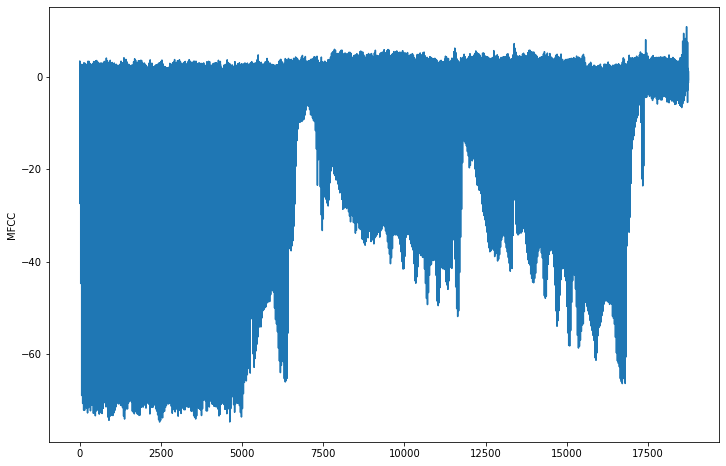

In [5]:
#Calculate MFCC(Mel-frequency Cepstral Coefficients)
mfccs = ddsp.spectral_ops.compute_mfcc(
    audio,
    lo_hz=20.0,
    hi_hz=8000.0,
    fft_size=1024,
    mel_bins=128,
    mfcc_bins=30)

# Plot MFCC.
plt.figure(figsize=(12, 8))
plt.plot(np.ravel(mfccs), label='MFCC')
plt.ylabel('MFCC')


### Another way to compute f0 and loudness

In [6]:
# # Setup the session.
# ddsp.spectral_ops.reset_crepe()

# # Compute features.
# audio_features = ddsp.training.metrics.compute_audio_features(audio)
# audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
# audio_features_mod = None

# TRIM = -15
# # Plot Features.
# fig, ax = plt.subplots(nrows=3, 
#                        ncols=1, 
#                        sharex=True,
#                        figsize=(6, 8))
# ax[0].plot(audio_features['loudness_db'][:TRIM])
# ax[0].set_ylabel('loudness_db')

# ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
# ax[1].set_ylabel('f0 [midi]')

# ax[2].plot(audio_features['f0_confidence'][:TRIM])
# ax[2].set_ylabel('f0 confidence')
# _ = ax[2].set_xlabel('Time step [frame]')

## Load the model(without z encoder)

In [7]:
# set paths
dataset_stats_file = 'Pretraine_ models_for_T2/DDSP_saxophone_without_z/my_solo_instrument/dataset_statistics.pkl'
gin_file = 'Pretraine_ models_for_T2/DDSP_saxophone_without_z/my_solo_instrument/operative_config-0.gin'
model_dir = 'Pretraine_ models_for_T2/DDSP_saxophone_without_z/my_solo_instrument'

In [8]:
# Load the dataset statistics.
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))


# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[0] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:n_samples]


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)


Loading dataset statistics from Pretraine_ models_for_T2/DDSP_saxophone_without_z/my_solo_instrument/dataset_statistics.pkl
Loading dataset statistics from pickle failed: name 'pickle' is not defined.


tf.Tensor(
[[ 0.00476101  0.00608918  0.00655844 ... -0.02762157 -0.01578972
  -0.00652495]], shape=(1, 160000), dtype=float32)
Original
Resynthesis


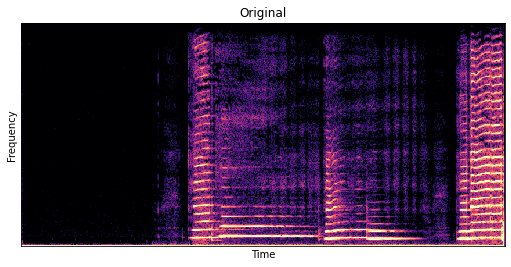

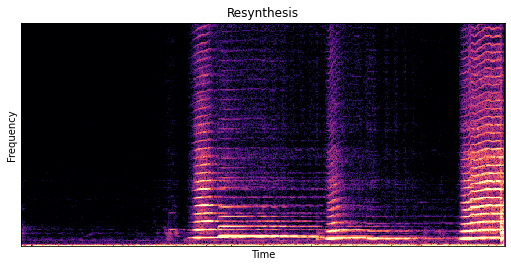

In [10]:
# Resynthesize audio.
outputs = model(audio_features, training=False) # Run the forward pass, add losses, and create a dictionary of outputs.
# print(outputs.keys())
# dict_keys(['inputs', 'audio', 'f0_hz', 'f0_confidence', 'loundness_db', 
#           'f0_condience', 'loudness_db', 'f0_scaled', 'ld_scaled', 'amps', 
#           'harmonic_distribution', 'noise_magnitudes', 'harmonic', 'filtered_noise', 
#           'add', 'reverb', 'out', 'audio_synth'])

audio_gen = outputs['audio_synth']
print(audio_gen)

# Plot
print('Original')
ipd.Audio(audio, rate = sample_rate) 
utils.specplot(audio)
plt.title("Original")

print('Resynthesis')
ipd.Audio(audio_gen, rate = sample_rate) 
utils.specplot(audio_gen)
_ = plt.title("Resynthesis")

## Comparing the results